<a href="https://colab.research.google.com/github/drugescu/face-recognition/blob/master/MobileNetSSDv1_FaceDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
!python --version

Python 3.6.9


In [28]:
!sudo pip3 install mtcnn

In [0]:
from __future__ import print_function
import collections
import io
import math
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
import scipy
from IPython import display
from sklearn import metrics
from PIL import Image
#from mtcnn import MTCNN
import cv2
from google.colab.patches import cv2_imshow

In [5]:
base_path = "/content/drive/My Drive/Datasets/MS-Celeb-1M/"
train_path = "/content/drive/My Drive/Datasets/MS-Celeb-1M/15_id.tfrecords"
print(base_path)

/content/drive/My Drive/Datasets/MS-Celeb-1M/


# Load images from tfrecord

In [6]:
# Actual parsing function
def parse(example_proto):
    features = { 
        'image_raw': tf.io.FixedLenFeature([], tf.string), 
        'label': tf.io.FixedLenFeature([], tf.int64) 
    }
    features = tf.io.parse_single_example(example_proto, features)
    img = tf.image.decode_jpeg(features['image_raw'])
    # Load image, decode jpeg, cast to float 32 and normalize
    img = tf.cast(img, dtype = tf.float32) * (1. / 255)
    # Cast label as uint8
    label = tf.cast(features['label'], tf.uint8) # was tf.int64
    return img, label

# Create the Dataset object.
ds = tf.data.TFRecordDataset(train_path)
print("Dataset after loading from file   :", ds)

# Map features and labels with the parse function.
ds = ds.map(parse)
print("Dataset after conversion and norm.:", ds)

# Shuffle dataset
ds = ds.shuffle(buffer_size = 5000)
print("Dataset after shuffling           :", ds)

# Get vector of all images
all_recs = ds.take(-1)
imgs = []
labels = []

for image, label in all_recs:
  imgs.append(image.numpy())
  labels.append(label.numpy())

test_imgs = np.asarray(imgs)
test_labels = np.asarray(labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

Dataset after loading from file   : <TFRecordDatasetV2 shapes: (), types: tf.string>
Dataset after conversion and norm.: <MapDataset shapes: ((None, None, None), ()), types: (tf.float32, tf.uint8)>
Dataset after shuffling           : <ShuffleDataset shapes: ((None, None, None), ()), types: (tf.float32, tf.uint8)>


# Load model

In [7]:
inference_model = tf.keras.models.load_model('/content/drive/My Drive/Datasets/MS-Celeb-1M/15id_inference_model.h5')
inference_model.load_weights('/content/drive/My Drive/Datasets/MS-Celeb-1M/15id_inference_model_weights.h5')

inference_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_pad (ZeroPadding2D)    (None, 113, 113, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 56, 56, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 56, 56, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 56, 56, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 56, 56, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 56, 56, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 56, 56, 32)        0

# Predict all tfrecord images

In [8]:
#Predict all
predictions = inference_model.predict(test_imgs)
print("Embedding :", predictions)
print("Length of embedding :", len(predictions))

Embedding : [[[[0.         0.         0.         ... 0.61338574 0.28179193
    0.25884762]]]


 [[[0.         0.02793267 0.00147423 ... 0.         0.99352574
    1.4035516 ]]]


 [[[0.         0.21703026 0.00444577 ... 1.0737809  0.10885929
    0.        ]]]


 ...


 [[[0.         0.         0.12134845 ... 0.13374121 0.25441152
    0.23526637]]]


 [[[0.         0.         0.         ... 0.         0.79516906
    1.2083356 ]]]


 [[[0.17887245 0.11478775 0.6594448  ... 0.04700692 0.
    0.69152606]]]]
Length of embedding : 1218


# Face detection

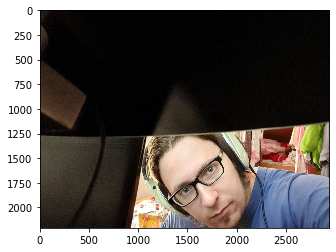

In [9]:
image = Image.open('/content/drive/My Drive/Datasets/MS-Celeb-1M/dragos1.jpg')
image = image.convert('RGB')
pixels = np.asarray(image)
plt.imshow(pixels)

In [13]:
from mtcnn.mtcnn import MTCNN
print("MTCNN version :", mtcnn.__version__)
import keras
print("Keras version :", keras.__version__)
detector = MTCNN()

MTCNN version : 0.0.9
Keras version : 2.2.5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [0]:
def extract_face(filename, detector_instance, required_size = (112,112)):
  
  # Load image
  image = Image.open(filename)
  image = image.convert('RGB')
  pixels = np.asarray(image)

  # Detect face
  detector = detector_instance
  results = detector.detect_faces(pixels)

  # If multiple faces in picture, output error
  if (len(results) > 1):
    print("Detected more than one face!")
    return ["Error"]

  # Extract indices of face
  x1, y1, width, height = results[0]['box']
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + width

  # Extract face
  face = pixels[y1:y2, x1:x2]

  # Resize to proper dimension
  img_face = Image.fromarray(face)
  img_face = img_face.resize(required_size)
  face_array = np.asarray(img_face)

  return (results, face_array)

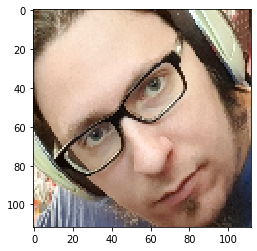

In [21]:
face1 = extract_face("/content/drive/My Drive/Datasets/MS-Celeb-1M/dragos1.jpg", detector, (112,112))
plt.imshow(face1[1])

In [31]:
print(face1[0][0]['keypoints']['left_eye'])
keypoints = face1[0][0]['keypoints']

(1505, 1895)


left eye  : (1505, 1895)
right eye : (1755, 1622)
Angle between eyes (-pi to pi) in radians : 0.829346901429562
In degrees : 47.51807720416621


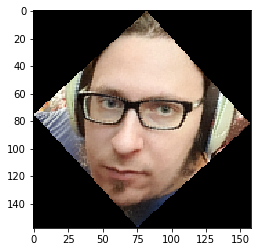

In [33]:
# Ne trebuie o functie de frontalizare (indreptare unghi si perspectiva)
# Idee frontalizare - rotire cu unghiul dintre ochi
print("left eye  :", keypoints['left_eye'])
print("right eye :", keypoints['right_eye'])

# Y axis grows downward, X axis grows to the right
def angle_eyes(left_eye, right_eye):
  if (left_eye[1] > right_eye[1]):
    # left eye is below
    third_point = (right_eye[0], left_eye[1])
    P1x, P1y = left_eye[0], left_eye[1]
    P2x, P2y = right_eye[0], right_eye[1]
    P3x, P3y = third_point[0], third_point[1]
  else:
    # left eye is above
    third_point = (left_eye[0], right_eye[1])
    P1x, P1y = right_eye[0], right_eye[1]
    P2x, P2y = left_eye[0], left_eye[1]
    P3x, P3y = third_point[0], third_point[1]

  # atan2(y, x) returns the angle from that point and the X+ axis wrt to the origin
  # Perform a translation to P1, P1 becomes origin
  angle = math.atan2(P3y - P1y, P3x - P1x) - math.atan2(P2y - P1y, P2x - P1x);

  return angle

def angle_eyes_deg(left_eye, right_eye):
  return (angle_eyes(left_eye, right_eye) / math.pi) * 180.0

angle     = angle_eyes(keypoints['left_eye'], keypoints['right_eye'])
angle_deg = angle_eyes_deg(keypoints['left_eye'], keypoints['right_eye'])
print("Angle between eyes (-pi to pi) in radians :", angle)
print("In degrees :", angle_deg)

face1_rot = scipy.ndimage.rotate(face1[1], -angle_deg)
plt.imshow(face1_rot)

# Metrics for evaluation

In [34]:
loss = print(tf.keras.losses.cosine_similarity(
    predictions[0],
    predictions[1],
    axis=-1
))

tf.Tensor([[-0.71291226]], shape=(1, 1), dtype=float32)


# Utils

For MTCNN to work for tensorflow 2.0 you must download (git clone) the repo at https://github.com/instabotai/instabotai, then package the mtcnn folder into a zip (mtcnn.zip) and upload it using google drive. We will install this zip file in the python directory and import it (0.0.9). The default pip installation (0.1.0) doesn't work.

In [60]:
!ls "/content/drive/My Drive/Datasets/MS-Celeb-1M/"

15id_inference_model.h5		 15id_model_weights.h5	dragos1.jpg
15id_inference_model_weights.h5  15_id.tfrecords	mtcnn
15id_model.h5			 dragos1_detection.jpg	mtcnn.zip


In [59]:
!unzip /content/drive/My\ Drive/Datasets/MS-Celeb-1M/mtcnn.zip -d /content/drive/My\ Drive/Datasets/MS-Celeb-1M

Archive:  /content/drive/My Drive/Datasets/MS-Celeb-1M/mtcnn.zip
   creating: /content/drive/My Drive/Datasets/MS-Celeb-1M/mtcnn/
  inflating: /content/drive/My Drive/Datasets/MS-Celeb-1M/mtcnn/layer_factory.py  
   creating: /content/drive/My Drive/Datasets/MS-Celeb-1M/mtcnn/data/
  inflating: /content/drive/My Drive/Datasets/MS-Celeb-1M/mtcnn/data/mtcnn_weights.npy  
  inflating: /content/drive/My Drive/Datasets/MS-Celeb-1M/mtcnn/network.py  
  inflating: /content/drive/My Drive/Datasets/MS-Celeb-1M/mtcnn/__init__.py  
  inflating: /content/drive/My Drive/Datasets/MS-Celeb-1M/mtcnn/mtcnn.py  
   creating: /content/drive/My Drive/Datasets/MS-Celeb-1M/mtcnn/exceptions/
  inflating: /content/drive/My Drive/Datasets/MS-Celeb-1M/mtcnn/exceptions/__init__.py  


In [62]:
!ls "/content/drive/My Drive/Datasets/MS-Celeb-1M/mtcnn"

data  exceptions  __init__.py  layer_factory.py  mtcnn.py  network.py


In [64]:
import sys
print (sys.path)

['/tensorflow-2.1.0/python3.6', '', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


In [0]:
!cp -r "/content/drive/My Drive/Datasets/MS-Celeb-1M/mtcnn/" "/usr/local/lib/python3.6/dist-packages/"

In [77]:
!ls /usr/local/lib/python3.6/dist-packages/mtcnn

data  exceptions  __init__.py  layer_factory.py  mtcnn.py  network.py


In [73]:
!sudo pip3 uninstall mtcnn

Uninstalling mtcnn-0.1.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/mtcnn-0.1.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/mtcnn/*
Proceed (y/n)? y
  Successfully uninstalled mtcnn-0.1.0


In [0]:
del mtcnn
import mtcnn

In [35]:
print (mtcnn.__version__)

0.0.9
